In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap



In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'

birds = [
    os.path.basename(bird)
    for bird in sorted(glob.glob(os.path.join(rootPath+dataPath, "*")), key=os.path.getmtime, reverse=True)
    if (os.path.isdir(bird))]

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

In [4]:
dfDataBase

,bird,site,unit,stim,call,trial,R,z,PC
0,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,0,1.0,0.670113,"[-371.0872844018543, 67.70692230077798, 37.709..."
1,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,1,-1.0,-0.670113,"[-390.8290974752949, -8.252893698728801, -4.97..."
2,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,2,1.0,0.670113,"[-381.22954095551694, -11.739478782846223, 33...."
3,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,3,0.0,0.000000,"[-413.3700305165536, 19.789477797457508, 14.91..."
4,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_1_fs25k.wav,Ag,0,0.0,0.000000,"[-413.3700305165536, 19.789477797457508, 14.91..."
...,...,...,...,...,...,...,...,...,...
126662,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Te_5-3-1_fs25k.wav,Te,0,1.0,0.238918,"[-378.17102168090486, 12.554790689628675, 65.4..."
126663,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Th_3-2-5_fs25k.wav,Th,0,3.0,0.716754,"[-255.3820547782913, -75.19637820136938, 160.6..."
126664,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Th_3-2-5_fs25k.wav,Th,1,-1.0,-0.238918,"[-279.4208127914937, -75.99459230690728, -75.2..."
126665,ZF4F,ZF4F_5t_190616_102456,goodPlayback-e20-c1.pkl,WhiWhi1415_FAF_Th_4-1-9_fs25k.wav,Th,0,0.0,0.000000,"[-342.855105432616, 69.0482290556694, -54.1635..."


In [5]:
# Number of Units
unitNames = np.unique(dfDataBase['site']+'_'+ dfDataBase['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBase['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBase['stim'][dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]))
    # Select only Units with 110 stimuli (for now)
    if (nstimsUnit[unit] == 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



191


In [6]:
# Read the results of Part 1 of DecodingCallType Runs that includes the 100 neurons chosen for the analysis.

# Read the PC and Confusion matrices data base
inPath = rootPath+dataPath+'HerminaDataBase1GoodUnitPC.pkl'
fileIn = open(inPath,"rb")
unitNamesGood = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pccGood = pk.load(fileIn)
selH = pk.load(fileIn)
fileIn.close()


In [7]:
indSort = np.flip(np.argsort(pccGood))

# Printing the name of the most discriminating units
for ind in indSort:
    print(unitNamesGood[ind], pccGood[ind])

['ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl'] 25.723443992662204
['ZF7F_7t_190806_115742_goodPlayback-e13-c0.pkl'] 19.913887413363454
['ZF5M_8t_190627_132428_goodPlayback-e12-c76.pkl'] 19.469587931789118
['ZF4F_2t_190613_101015.old_goodPlayback-e11-c62.pkl'] 18.969013028003097
['ZF4F_3t_190613_150928_goodPlayback-e17-c97.pkl'] 18.407321658085664
['ZF4F_2t_190612_134337_goodPlayback-e17-c55.pkl'] 17.527376552936182
['ZF7F_7t_190806_115742_goodPlayback-e10-c65.pkl'] 17.24209383648092
['ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl'] 17.228639685348195
['ZF4F_2t_190612_134337_goodPlayback-e16-c98.pkl'] 16.79742152186522
['ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl'] 16.614612365305483
['ZF4F_2t_190612_101201_goodPlayback-e20-c54.pkl'] 16.490082611741798
['ZF7F_6t_190724_104215_goodPlayback-e19-c53.pkl'] 15.703764697893888
['ZF4F_3t_190613_150928_goodPlayback-e20-c99.pkl'] 15.632020061625362
['ZF4F_2t_190613_101015.old_goodPlayback-e16-c63.pkl'] 15.60808045065237
['ZF4F_2t_190

In [7]:
# THis is to load the neurons that did well as a group of 20  

inPath = rootPath+ dataPath + 'HerminaDataBase20GoodUnitPCPerZone.pkl'
fileIn = open(inPath,"rb")
argListZones = pk.load(fileIn)
confMatZones = pk.load(fileIn)
pccZones = pk.load(fileIn)
selHZones = pk.load(fileIn)
zoneUnique = pk.load(fileIn)
fileIn.close()



In [8]:
for izone, zone in enumerate(zoneUnique):
    print(zone, len(pccZones[izone]))

L-CML 1001
NCM-CMM 1001


In [9]:
# Take the one group with the highest pcc
indListMaxZones = []
for izone, zone in enumerate(zoneUnique):

    indListMax = np.argwhere(pccZones[izone] == pccZones[izone].max())[0][0]
    print(zone, ':')
    print(argListZones[izone+1][indListMax])
    print(pccZones[izone][indListMax])
    print()
    indListMaxZones.append(indListMax)

L-CML :
['ZF5M_10_5t_190703_133641_goodPlayback-e18-c48.pkl'
 'ZF4F_2t_190612_101201_goodPlayback-e17-c36.pkl'
 'ZF6M_8t_190725_105432_goodPlayback-e15-c67.pkl'
 'ZF7F_4_5t_190718_091732_goodPlayback-e9-c1.pkl'
 'ZF7F_5_5t_190722_121506_goodPlayback-e11-c1.pkl'
 'ZF5M_12t_190707_102304_goodPlayback-e10-c1.pkl'
 'ZF4F_6t_190616_142033_goodPlayback-e16-c70.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e11-c27.pkl'
 'ZF7F_5t_190720_152938_goodPlayback-e18-c12.pkl'
 'ZF5M_11t_190704_100420_goodPlayback-e13-c14.pkl'
 'ZF4F_2t_190612_134337_goodPlayback-e17-c57.pkl'
 'ZF5M_12t_190707_102304_goodPlayback-e19-c55.pkl'
 'ZF6M_9_5t_190805_102553_goodPlayback-e19-c71.pkl'
 'ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl'
 'ZF4F_6t_190616_142033_goodPlayback-e19-c38.pkl'
 'ZF4F_2t_190612_101201_goodPlayback-e8-c38.pkl'
 'ZF5M_11t_190704_100420_goodPlayback-e10-c51.pkl'
 'ZF4F_2t_190612_101201_goodPlayback-e19-c2.pkl'
 'ZF5M_8t_190627_132428_goodPlayback-e11-c50.pkl'
 'ZF5M_9_5t_190701_125653_goodPlayb

In [10]:
# Take the one group with one of the lowest pcc
# Take the one group with the lowest pcc
indListMinZones = []
for izone, zone in enumerate(zoneUnique):

    indListMin = np.argwhere(pccZones[izone] == pccZones[izone].min())[0][0]
    print(zone, ':')
    print(argListZones[izone+1][indListMin])
    print(pccZones[izone][indListMin])
    print()
    indListMinZones.append(indListMin)

L-CML :
['ZF7F_4_5t_190718_091732_goodPlayback-e9-c1.pkl'
 'ZF6M_9_5t_190805_130046_goodPlayback-e19-c63.pkl'
 'ZF4F_7t_190619_095313_goodPlayback-e19-c49.pkl'
 'ZF7F_5t_190720_152938_goodPlayback-e18-c12.pkl'
 'ZF5M_9_5t_190701_125653_goodPlayback-e10-c115.pkl'
 'ZF5M_12t_190707_102304_goodPlayback-e19-c55.pkl'
 'ZF4F_2t_190612_101201_goodPlayback-e8-c38.pkl'
 'ZF6M_7_5t_190723_100723_goodPlayback-e13-c131.pkl'
 'ZF6M_7_5t_190723_141539_goodPlayback-e14-c23.pkl'
 'ZF7F_4_5t_190718_091732_goodPlayback-e17-c1.pkl'
 'ZF4F_6t_190616_142033_goodPlayback-e19-c38.pkl'
 'ZF4F_2t_190613_101015.old_goodPlayback-e20-c134.pkl'
 'ZF7F_5_5t_190722_121506_goodPlayback-e13-c15.pkl'
 'ZF4F_3t_190613_150928_goodPlayback-e17-c97.pkl'
 'ZF7F_6t_190724_104215_goodPlayback-e19-c54.pkl'
 'ZF4F_2t_190613_101015.old_goodPlayback-e19-c60.pkl'
 'ZF4F_5t_190615_114154_goodPlayback-e20-c56.pkl'
 'ZF7F_7t_190806_115742_goodPlayback-e13-c0.pkl'
 'ZF7F_7_5t_190807_105305_goodPlayback-e19-c41.pkl'
 'ZF7F_5_5t_190722_

In [11]:
# Read the Modulation Transfer Functions

inPath = rootPath+ dataPath + 'HerminaGoodUnitsMPS_PC.pkl'

fileIn = open(inPath,"rb")
unitNamesGood= pk.load(fileIn)
mpsAVGList = pk.load(fileIn)
mpsTRGList = pk.load(fileIn)
wt = pk.load(fileIn)
wf = pk.load(fileIn)
fileIn.close()



In [12]:
# Calculate relative power in each componnent.
allz = []
allPC = []
neuralNoise = np.zeros(len(unitNamesGood,))

for i,unit in enumerate(unitNamesGood):
    unitIndex = dfDataBase.index[dfDataBase['site']+'_'+ dfDataBase['unit'] == unit[0]]
    unitNoise = {'Be': [], 'LT': [], 'Th': [], 
             'Di': [], 'Ag': [], 'Wh': [], 'Ne': [ ],
             'Te': [], 'DC': [], 'So': []}
    for ind in unitIndex:
        allz.append(dfDataBase['z'][ind])
        allPC.append(dfDataBase['PC'][ind])
        unitNoise[dfDataBase['call'][ind]].append(dfDataBase['z'][ind])
    
    unitNoiseComb = 0
    for callType in unitNoise:
        mean = np.mean(unitNoise[callType])
        std = np.std(unitNoise[callType])
        #if mean == 0 :
        #    unitNoiseComb += 1
        #else:
        #    unitNoiseComb += std/np.abs(mean)
        unitNoiseComb += std**2
    neuralNoise[i] = unitNoiseComb/10.0
        
stdz = np.std(allz)
stdPC = np.std(np.array(allPC), axis = 0)



In [13]:
# Read the Modulation Power Spectra and Spectrogram

inPath = rootPath+ dataPath + 'HerminaStimMPS.pkl'

fileIn = open(inPath,"rb")
callMPS = pk.load(fileIn)
wt = pk.load(fileIn)
wf = pk.load(fileIn)
callSpectro = pk.load(fileIn)
fileIn.close()


In [14]:
# Between and Within Covariances
indTLow = np.argwhere(wt>-50)[0][0]
indTHigh = np.argwhere(wt>50)[0][0]
indFLow = np.argwhere(wf>=0)[0][0]
indFHigh = np.argwhere(wf*1000>4)[0][0]

callMPSMeans = []
for calltype in callMPS:
    for i, mps in enumerate(callMPS[calltype]):
        if i == 0:
            mpsavg = np.copy(mps[indFLow:indFHigh, indTLow:indTHigh])
        else:
            mpsavg += mps[indFLow:indFHigh, indTLow:indTHigh]
    
    callMPSMeans.append((mpsavg/len(callMPS[calltype])).flatten())
    
betweenCov = np.cov(np.array(callMPSMeans).transpose())


withinCovCall = []
overallCovData = []
for icall, calltype in enumerate(callMPS):
    callMPSWithin = []
    for mps in callMPS[calltype]:
        mpstemp = np.copy(mps[indFLow:indFHigh, indTLow:indTHigh])
        callMPSWithin.append(mpstemp.flatten() - callMPSMeans[icall])
        overallCovData.append(mpstemp.flatten())
        
    withinCovCall.append(np.cov(np.array(callMPSWithin).transpose()))
    
withinCov = np.mean(withinCovCall, axis = 0)
overallCov = np.cov(np.array(overallCovData).transpose())

In [15]:
# Look at the DFA Space:
eigMatrix = np.matmul(np.linalg.pinv(withinCov, rcond = 0.0001, hermitian=True), betweenCov)
#eigMatrix = betweenCov
#eigMatrix = overallCov
eigVal, eigVect = np.linalg.eigh(eigMatrix)

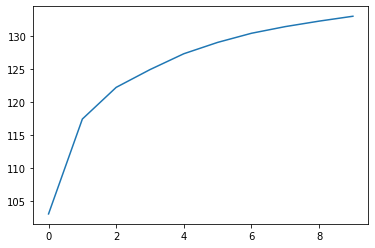

In [16]:
plt.plot(np.cumsum(np.abs(eigVal[0:10])))

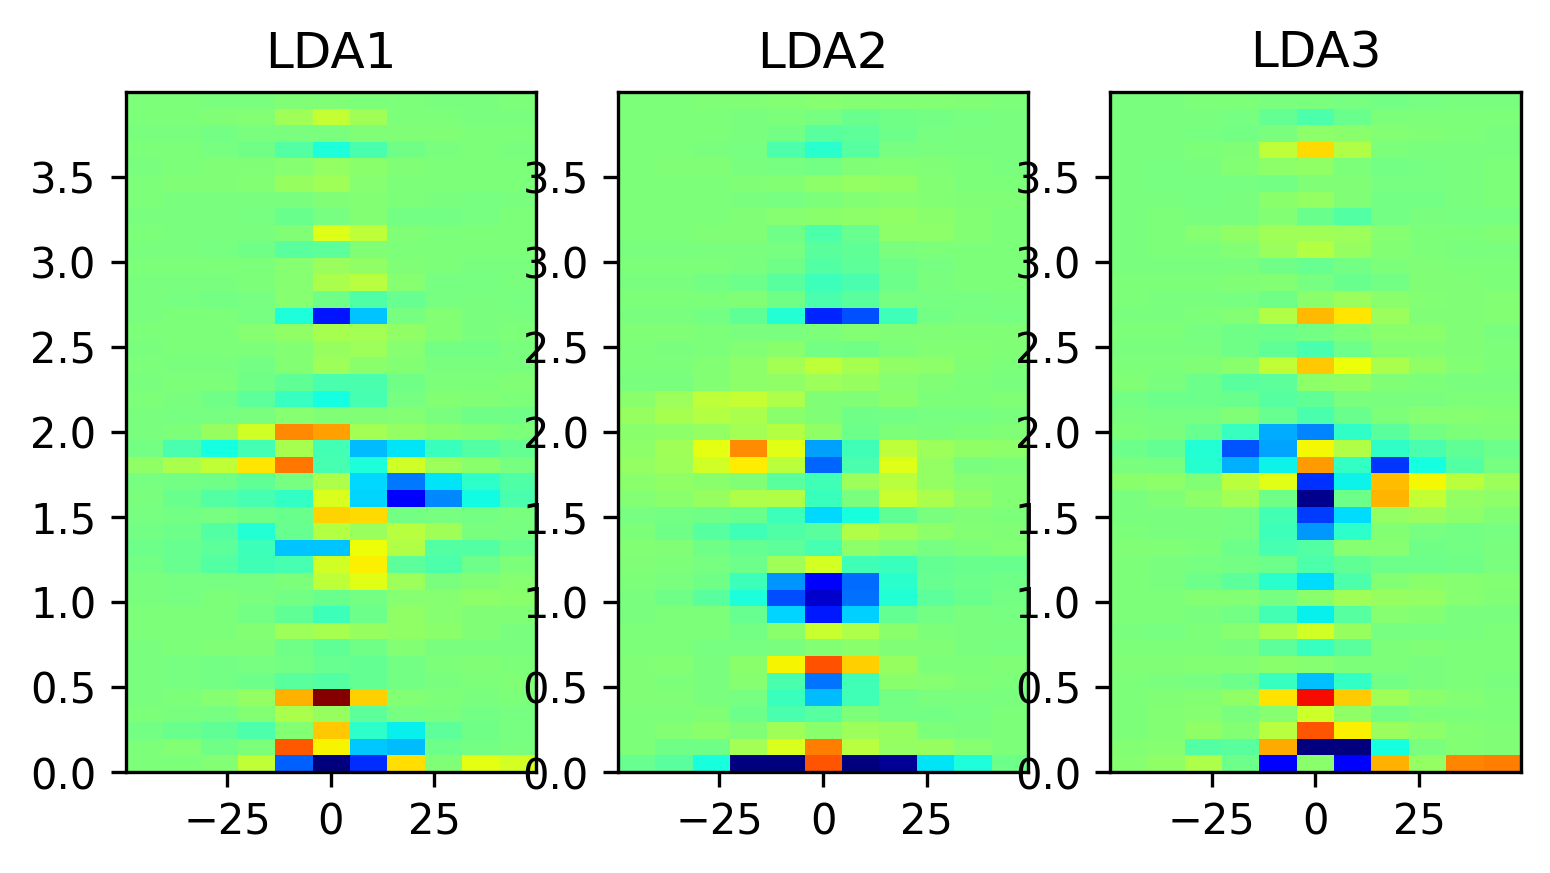

In [17]:
plt.figure(dpi=300, figsize= (6, 3))
ex = (wt[indTLow], wt[indTHigh-1], wf[indFLow]*1e3, wf[indFHigh-1]*1e3)
cmap = plt.get_cmap('jet')
                
for iplot in range(3):
    plt.subplot(1,3,1+iplot)
    plt.imshow(np.reshape(eigVect[:,iplot], mpstemp.shape), interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    plt.clim(-0.25,0.25)

    plt.title('LDA%d' % (iplot+1))
        
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


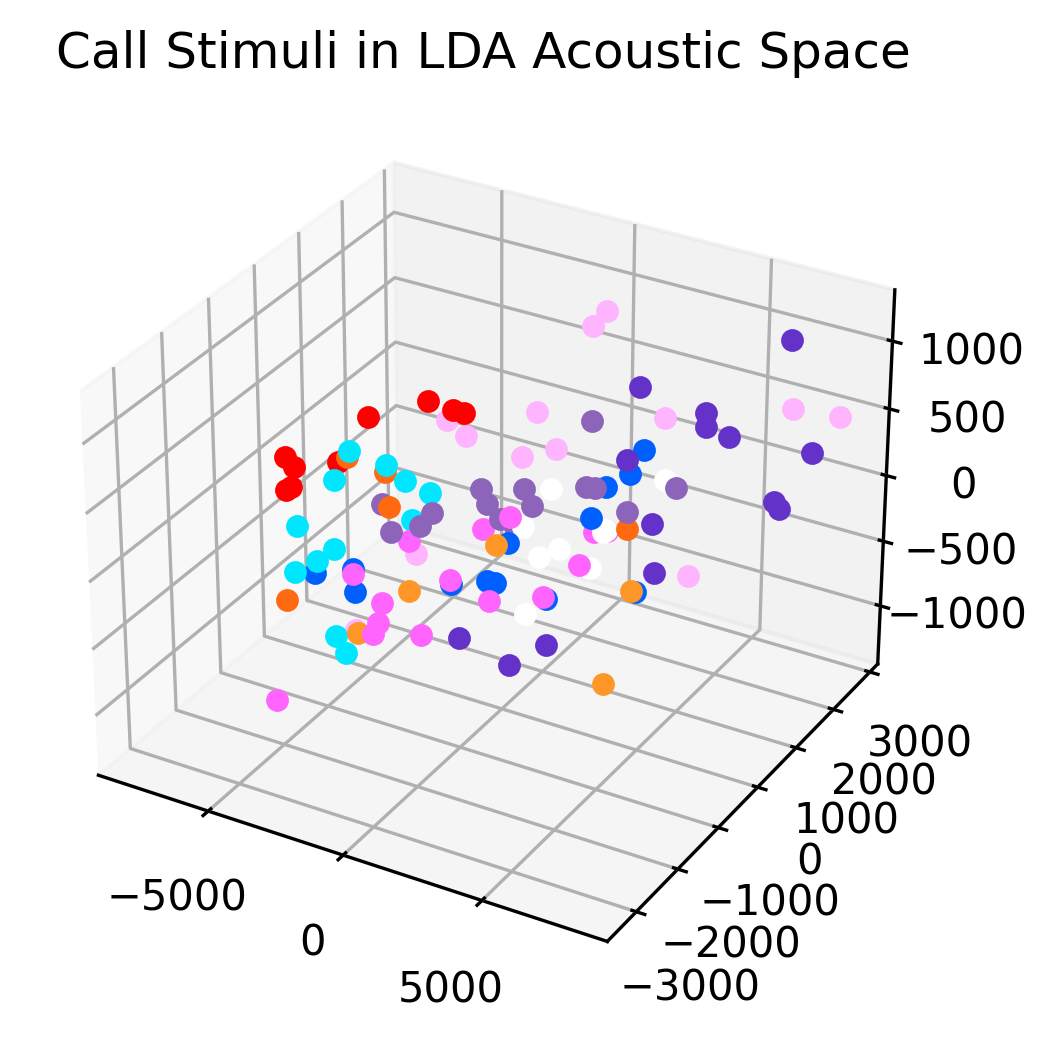

In [18]:
# Make a scatter plot to show call type centroids in PC space

callMPSLDA = {'Be': [], 'LT': [], 'Th': [], 
             'Di': [], 'Ag': [], 'Wh': [], 'Ne': [],
             'Te': [], 'DC': [], 'So': []}
   
for icall, calltype in enumerate(callMPS):
    for mps in callMPS[calltype]:
        mpstemp = mps[indFLow:indFHigh, indTLow:indTHigh]
        mpstemp = mpstemp.flatten()    
        # print(calltype, ':', np.std(mpstemp))
        callMPSLDA[calltype].append(np.array([np.dot(eigVect[:,0], mpstemp), np.dot(eigVect[:,1], mpstemp), np.dot(eigVect[:,2], mpstemp) ]))
        
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
for calltype in callMPSLDA:
    for xyz in callMPSLDA[calltype]:
        ax.scatter(xyz[0], xyz[1], xyz[2], marker = 'o', color = callColor[calltype])
        
plt.title('Call Stimuli in LDA Acoustic Space')
        
plt.savefig('/Users/frederictheunissen/Desktop/callTypeLDA.eps')
    

In [19]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform



In [20]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

In [22]:
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

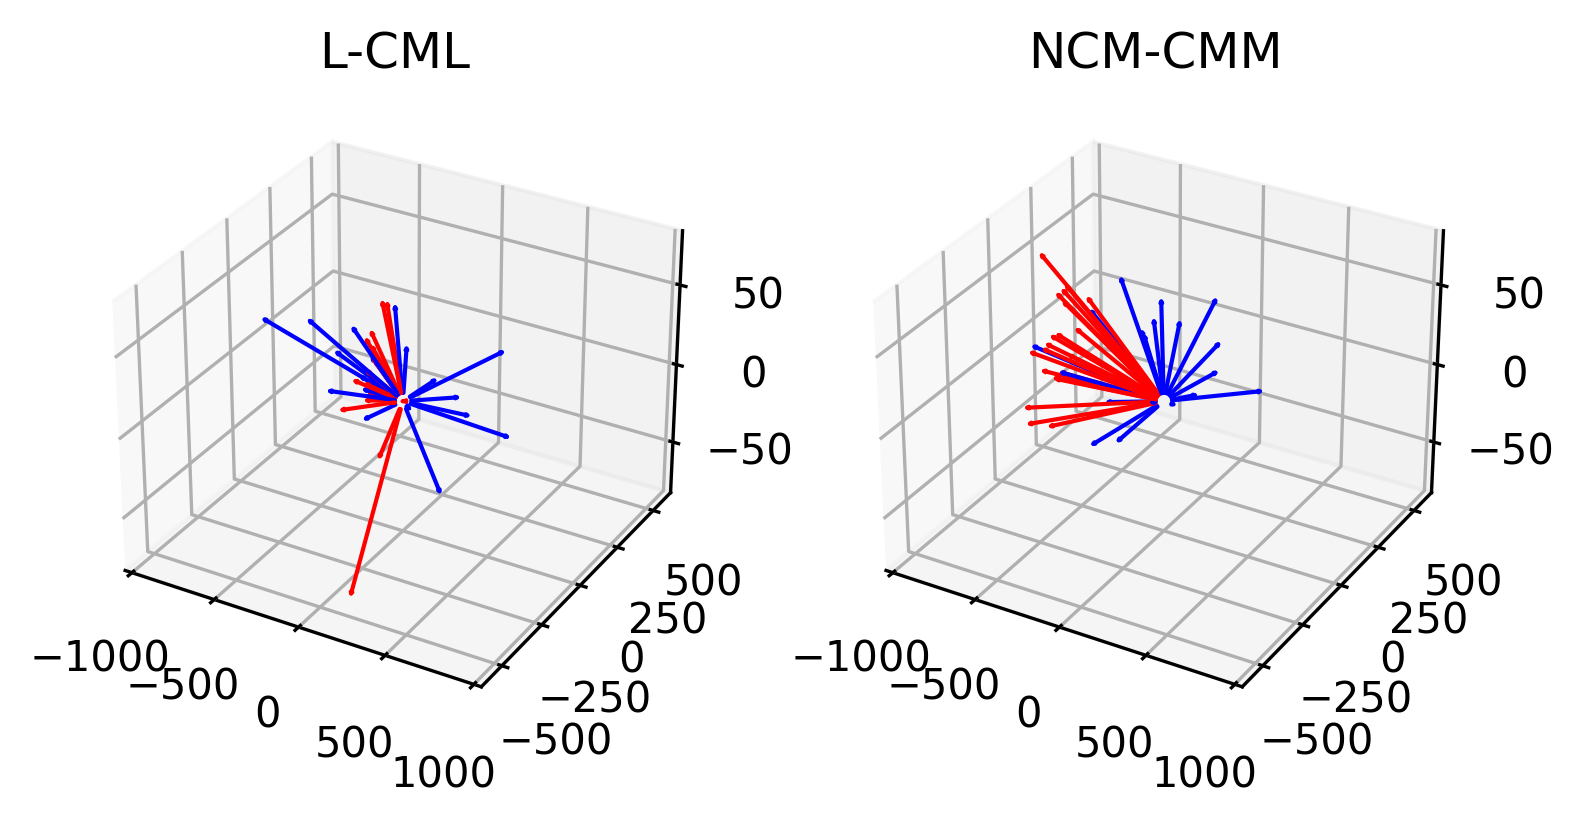

In [23]:
# Plot MTF of best and worst 20 Neurons in LDA space.

fig = plt.figure(dpi=300)
nZones = len(zoneUnique)

for izone, zone in enumerate(zoneUnique):

    # Calculate the position of the best neurons
    unitMTFLDABest = []
    for unit in argListZones[izone+1][indListMaxZones[izone]]:
        indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
        mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
        x = np.dot(eigVect[:,0], mtf)/110
        y = np.dot(eigVect[:,1], mtf)/110
        z = np.dot(eigVect[:,2], mtf)/110
        unitMTFLDABest.append(np.array([x,y,z]))

    unitMTFLDABest = np.vstack(unitMTFLDABest)

    # Calculate the position of the worst neurons
    unitMTFLDAWorst = []
    for unit in argListZones[izone+1][indListMinZones[izone]]:
        indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
        mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
        x = np.dot(eigVect[:,0], mtf)/110
        y = np.dot(eigVect[:,1], mtf)/110
        z = np.dot(eigVect[:,2], mtf)/110
        unitMTFLDAWorst.append(np.array([x,y,z]))

    unitMTFLDAWorst = np.vstack(unitMTFLDAWorst)    
    
    
    # Plot the data

    ax = fig.add_subplot(1, nZones, izone+1, projection='3d')

    for i in range(unitMTFLDABest.shape[0]):
        ax.arrow3D(0, 0, 0, unitMTFLDABest[i,0], unitMTFLDABest[i,1], unitMTFLDABest[i,2], arrowstyle="-|>", color='blue', lw=1)
        ax.arrow3D(0, 0, 0, unitMTFLDAWorst[1,0], unitMTFLDAWorst[i,1],unitMTFLDAWorst[i,2], arrowstyle="-|>", color='red', lw= 1)

    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-600, 600)
    ax.set_zlim(-80, 80)
    ax.title.set_text(zone)
    # plt.title('Neuronal Sampling Acoustic Space')

plt.savefig('/Users/frederictheunissen/Desktop/NeuronZLDALinesPerZone.pdf')

In [24]:
print('Vol Best', np.power(np.prod(unitMTFLDABest.max(axis=0)-unitMTFLDABest.min(axis=0)),1/3))
print('Vol Worst', np.power(np.prod(unitMTFLDAWorst.max(axis=0)-unitMTFLDAWorst.min(axis=0)),1/3))

Vol Best 362.0299283063595
Vol Worst 399.12758667058813


In [25]:
np.linalg.det(np.cov(unitMTFLDABest.transpose()))

596606958505.4275

In [26]:
# Read data files 
inPathH = rootPath+dataPath+'summarySel.pkl'
fileInH = open(inPathH,"rb")
dfSummaryH = pk.load(fileInH)
fileInH.close()

# Add a field called site_unit to match what is in argList
dfSummaryH['site_unit'] = dfSummaryH['site']+ '_' + dfSummaryH['unit']

In [27]:
# This volume also uses the PC's

volumeLDAZones = []
noiseGroupZones = []
selHGroupZones = []
selzGroupZones = []

for izone, zone in enumerate(zoneUnique):
    argList = argListZones[izone+1]

    volumeLDA = np.zeros((len(argList),))
    noiseGroup = np.zeros((len(argList),))
    selHGroup = np.zeros((len(argList)))
    selzGroup = np.zeros((len(argList)))

    for ilist, unitList in enumerate(argList):
        unitMTFLDA = []
        noiseList = 0
        selHList = 0
        selzList = 0
        for unit in unitList:
            indUnit = np.argwhere(np.array(unitNamesGood) == unit)[0][0]
            mtf = np.copy(mpsTRGList[indUnit][0][indFLow:indFHigh, indTLow:indTHigh]).flatten()
            x = np.dot(eigVect[:,0], mtf)/(110*stdz)
            y = np.dot(eigVect[:,1], mtf)/(110*stdz)
            z = np.dot(eigVect[:,2], mtf)/(110*stdz)
            unitMTFLDA.append(np.array([x,y,z]))
            noiseList += neuralNoise[indUnit]
            selHList += selH[indUnit]
            selzList += dfSummaryH['selInd'][dfSummaryH['site_unit']==unit].values[0]
            for ipc in range(5):
                mtf = np.copy(mpsTRGList[indUnit][ipc+1][indFLow:indFHigh, indTLow:indTHigh]).flatten()
                x = np.dot(eigVect[:,0], mtf)/(110*stdPC[ipc])
                y = np.dot(eigVect[:,1], mtf)/(110*stdPC[ipc])
                z = np.dot(eigVect[:,2], mtf)/(110*stdPC[ipc])
                unitMTFLDA.append(np.array([x,y,z]))
        
        unitMTFLDA = np.vstack(unitMTFLDA)
    
        # Two ideas for volume:  the determinant of the covariance matrix or the power of max-min
        #volumeLDA[ilist] = np.power(np.prod(unitMTFLDA.max(axis=0)-unitMTFLDA.min(axis=0)),1/3)
        volumeLDA[ilist] = np.linalg.det(np.cov(unitMTFLDA.transpose()))
        noiseGroup[ilist] = noiseList/len(unitList)
        selHGroup[ilist] = selHList/len(unitList)
        selzGroup[ilist] = selzList/len(unitList)
        
    volumeLDAZones.append(volumeLDA)
    noiseGroupZones.append(noiseGroup)
    selHGroupZones.append(selHGroup)
    selzGroupZones.append(selzGroup)

In [28]:
def bivariateReg(x, y, xlabel = 'x', ylabel = 'y', title = 'Bivariate', xlim = [], ylim = [], ax = []):
    # Performs a bivariate regression, plots the line and stats.

    from random import sample
    from scipy.stats import f

    if ax == []:
        fig = plt.figure(figsize=(4,4), dpi=300)
        ax = plt.subplot()
    
    # Force x, y into numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    if xlim == []:
        xlim = (x.min(), x.max())
    if ylim == []:
        ylim = (y.min(), y.max())

    n = len(x)  # Data size

    # We are plotting a subset of the data
    if n > 1000 :
        selInd = sample(range(n), 1000)
    else:
        selInd = range(n)

    ax.scatter(x[selInd], y[selInd], s=1, color='grey', marker = ',')  
    
        
    # fit a linear curve an estimate its y-values and their error.
    a, b = np.polyfit(x, y, deg=1)

    # Calculate error and statistics
    sse = np.sum((y-(a*x+b))**2)
    xmean = np.mean(x)
    ssx = np.sum((x - xmean)**2)
    sst = np.sum((y-np.mean(y))**2)
    syx = np.sqrt(sse/(n-2))
    sy  = np.sqrt(sst/(n-1))
    r2adj = 1. - syx**2/sy**2
    fval = (sst-sse)/syx**2
    pval = 1. - f.cdf(fval, dfn=1, dfd=n-2)  # This is for independent data

    # Plot the regression line and error bars for the subset of points (to avoid clutter)
    xsel = x[selInd]
    ysel = y[selInd]
    indSort = np.argsort(xsel)
    xsel = xsel[indSort]
    ysel = ysel[indSort]
    
    y_est = a * xsel + b
    y_err = syx * np.sqrt(1/n + ((xsel - xmean)**2 / ssx) )


    ax.plot(xsel, y_est, '-')
    ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

    ax.set( xlim= xlim,
        ylim= ylim,
        ylabel=ylabel,
        xlabel=xlabel,
        title= title)

    # fig.colorbar(im_, ax=ax)
    #plt.savefig('/Users/frederictheunissen/Desktop/scatter%s%s.eps' % (xlabel, ylabel))
    return r2adj, fval, pval, sse, sst

In [29]:
# Calculate the number of units in each group to get the correct df
nZones = len(zoneUnique)
unitNumber = []
for izone, zone in enumerate(zoneUnique):
    unitNumber.append(np.unique(argListZones[izone+1]).shape[0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


L-CML : R2= 0.03964577184931939 F(1, 35 )= 1.5641613034964696 p= 0.2193535737527813
NCM-CMM : R2= 0.16511053633802597 F(1, 17 )= 3.7727308991773265 p= 0.06884931640873038


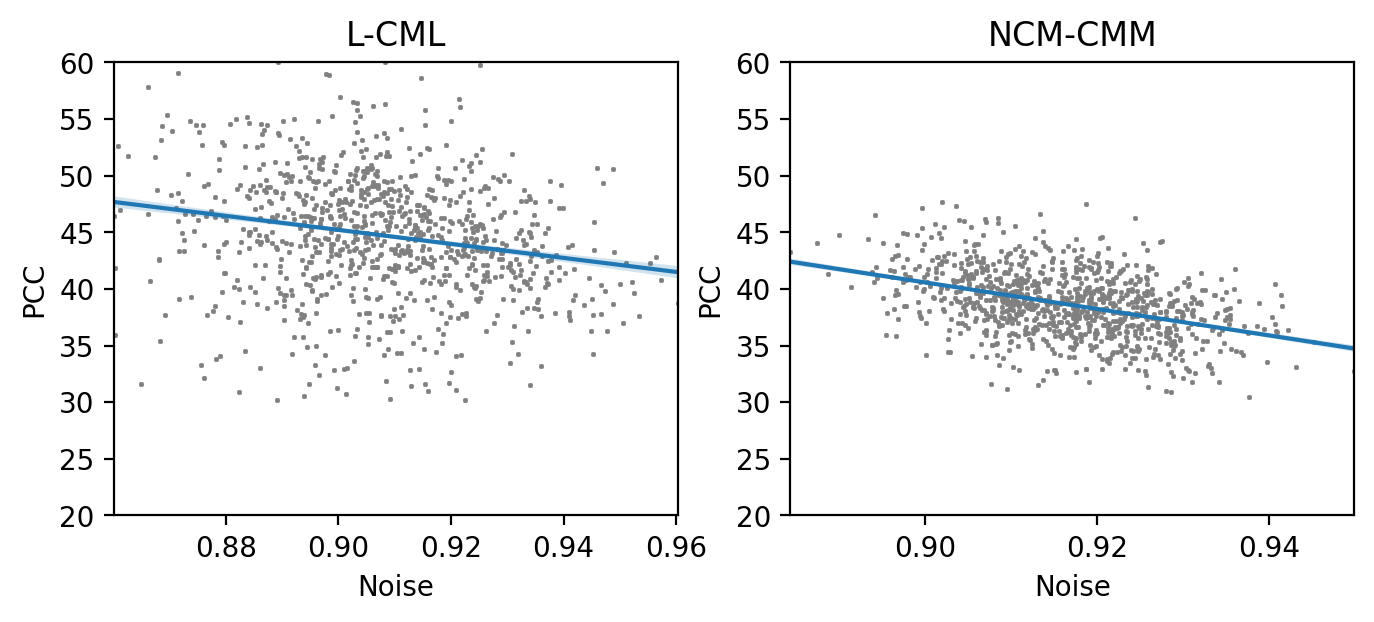

In [40]:
from scipy.stats import f
fig = plt.figure(figsize=(8,3), dpi=200)

nZones = len(zoneUnique)
for izone, zone in enumerate(zoneUnique):
    ax = plt.subplot(1, nZones, izone+1)
    indGood = (pccZones[izone] > 30)
    r2adj, fval, pval, sse, sst = bivariateReg(noiseGroupZones[izone][indGood], pccZones[izone][indGood], 
                                     xlabel = 'Noise', ylabel = 'PCC' , title=zone, ylim = (20,60), ax=ax)
    
    # dfd = unitNumber[izone]-2
    n = len(noiseGroupZones[izone])
    k = 2 # bivariate regression
    nE = 20
    nEff = unitNumber[izone] - nE + 1
    fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
    dfd = nEff - k
    pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)
    print(zone, ': R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)
    
plt.savefig('/Users/frederictheunissen/Desktop/scatterNoisePCCZone.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


L-CML : R2= 0.05931911894800734 F(1, 35 )= 2.36914392069887 p= 0.13274790718254992
NCM-CMM : R2= 0.06641318284779663 F(1, 17 )= 1.3692463195014255 p= 0.25808507163284067


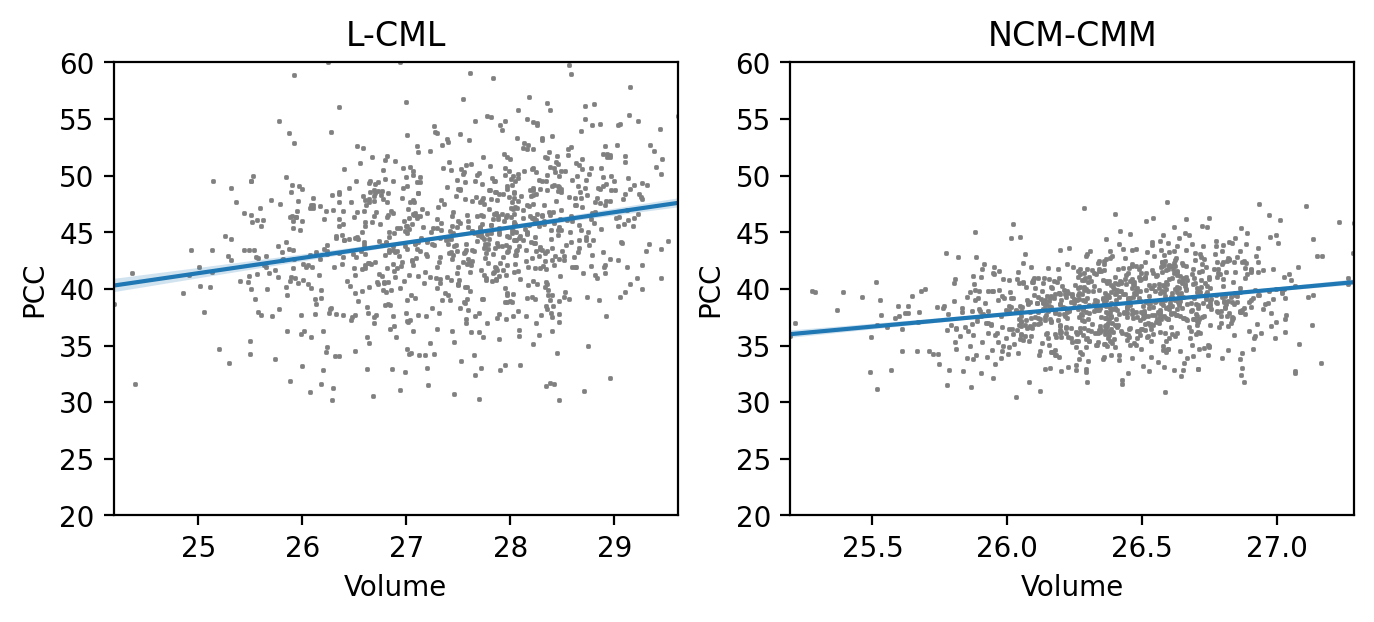

In [41]:
fig = plt.figure(figsize=(8,3), dpi=200)

nZones = len(zoneUnique)
for izone, zone in enumerate(zoneUnique):
    ax = plt.subplot(1, nZones, izone+1)

    indGood = (pccZones[izone] > 30)
    r2adj, fval, pval, sse, sst = bivariateReg(np.log(volumeLDAZones[izone][indGood]), pccZones[izone][indGood], 
                                     xlabel = 'Volume', ylabel = 'PCC' , title=zone, ylim = (20,60), ax=ax)
    
    n = len(pccZones[izone])
    k = 2 # bivariate regression
    nE = 20
    nEff = unitNumber[izone] - nE + 1
    fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
    dfd = nEff - k
    pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)
    
    print(zone, ': R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)
    
plt.savefig('/Users/frederictheunissen/Desktop/scatterVolumePCCZone.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


L-CML : R2= 0.00875402333882147 F(1, 35 )= 0.36462991086795515 p= 0.5498401569162059
NCM-CMM : R2= -0.0009723758341537714 F(1, 17 )= 0.000542264215804906 p= 0.9816928406474443


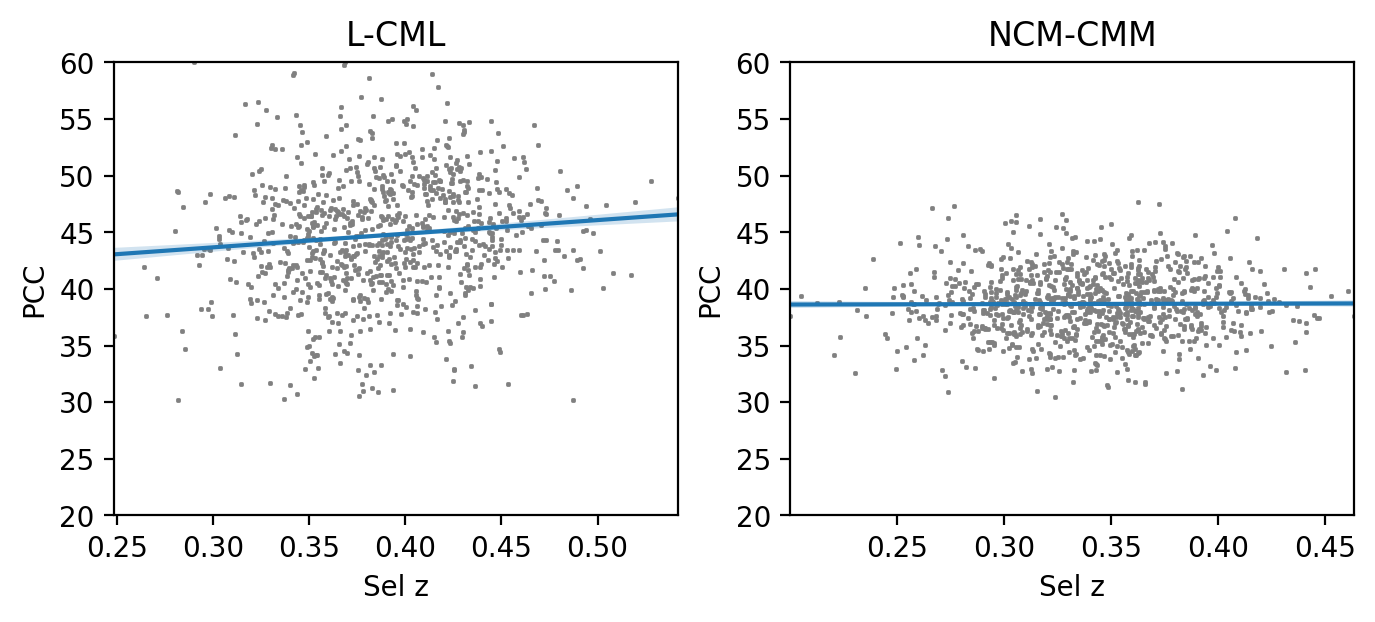

In [42]:
fig = plt.figure(figsize=(8,3), dpi=200)

nZones = len(zoneUnique)
for izone, zone in enumerate(zoneUnique):
    ax = plt.subplot(1, nZones, izone+1)

    indGood = (pccZones[izone] > 30)
    r2adj, fval, pval, sse, sst = bivariateReg(selzGroupZones[izone][indGood], pccZones[izone][indGood], 
                                     'Sel z', 'PCC', title = zone, ylim=(20,60), ax = ax)
    
    n = len(pccZones[izone])
    k = 2 # bivariate regression
    nE = 20
    nEff = unitNumber[izone] - nE + 1
    fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
    dfd = nEff - k
    pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)
    print(zone, ': R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)
    
plt.savefig('/Users/frederictheunissen/Desktop/scatterSelzPCCZone.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


L-CML : R2= 0.062282940521505736 F(1, 35 )= 2.493343446784446 p= 0.12332508437073508
NCM-CMM : R2= 0.06606572350384365 F(1, 17 )= 1.3616823025508038 p= 0.2593546616848089


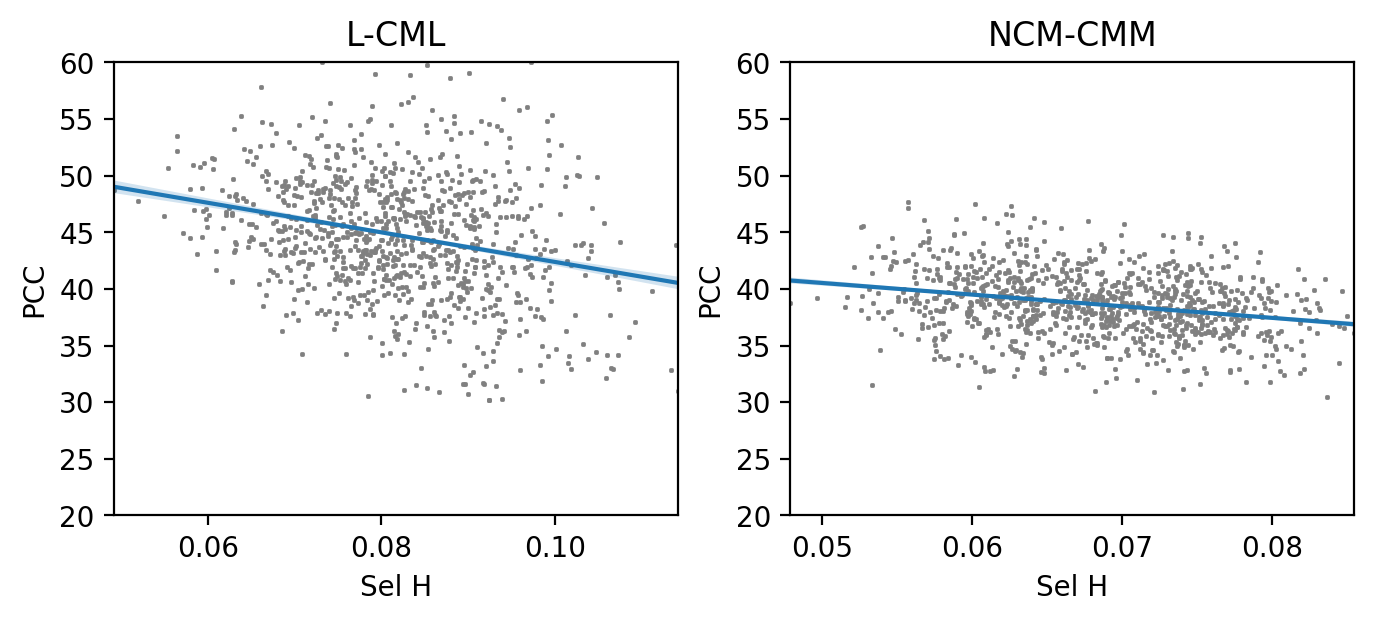

In [43]:
fig = plt.figure(figsize=(8,3), dpi=200)

nZones = len(zoneUnique)
for izone, zone in enumerate(zoneUnique):
    ax = plt.subplot(1, nZones, izone+1)

    indGood = (pccZones[izone] > 30)
    r2adj, fval, pval, sse, sst = bivariateReg(selHGroupZones[izone][indGood], pccZones[izone][indGood],
                                     'Sel H', 'PCC', title = zone, ylim=(20,60), ax = ax)
    
    n = len(pccZones[izone])
    k = 2 # bivariate regression
    nE = 20
    nEff = unitNumber[izone] - nE + 1
    fval = (nEff/n)*(sst-sse)/(sse/(n-k))       
    dfd = nEff - k
    pval = 1. - f.cdf(fval, dfn=1, dfd=dfd)
    print(zone, ': R2=', r2adj, 'F(1,', dfd, ')=' , fval, 'p=', pval)
    
plt.savefig('/Users/frederictheunissen/Desktop/scatterSelHPCCZone.eps')

In [44]:
from sklearn.linear_model import LinearRegression
from scipy.stats import f

for izone, zone in enumerate(zoneUnique):
    indGood = (pccZones[izone] > 30)
    X = np.vstack((noiseGroupZones[izone][indGood], np.log(volumeLDAZones[izone][indGood]), selHGroupZones[izone][indGood], selzGroupZones[izone][indGood])).transpose()
    y = pccZones[izone][indGood]

    myModel = LinearRegression().fit( X, y)
    y_pred = myModel.predict(X)

    # Calculate error and statistics
    n = len(y)       # Data points
    k = X.shape[1]+1
    sse = np.sum((y-(y_pred))**2)
    sst = np.sum((y-np.mean(y))**2)

    r2adj = 1. - (sse/(n-k))/(sst/(n-1))
    
    nE = 20
    nEff = unitNumber[izone] - nE + 1
    fval = (nEff/n)*((sst-sse)/(k-1))/(sse/(n-k))       
    dfd = nEff - k

    pval = 1. - f.cdf(fval, dfn=k-1, dfd=dfd)


    print(zone, ': R2=', r2adj, 'F(', k-1, ',', dfd, ')=' , fval, 'p=', pval)

L-CML : R2= 0.15205981176717365 F( 4 , 32 )= 1.6952601334051938 p= 0.17539040766618597
NCM-CMM : R2= 0.22790730010407512 F( 4 , 14 )= 1.419691318978466 p= 0.27856086885294384


In [45]:
for izone, zone in enumerate(zoneUnique):
    indGood = (pccZones[izone] > 30)
    X = np.vstack((noiseGroupZones[izone][indGood], np.log(volumeLDAZones[izone][indGood]))).transpose()
    y = pccZones[izone][indGood]

    myModel = LinearRegression().fit( X, y)
    y_pred = myModel.predict(X)

    # Calculate error and statistics
    n = len(y)       # Data points
    k = X.shape[1]+1   # Number of parameters in the model
    sse = np.sum((y-(y_pred))**2)
    sst = np.sum((y-np.mean(y))**2)

    r2adj = 1. - (sse/(n-k))/(sst/(n-1))

    nE = 20
    nEff = unitNumber[izone] - nE + 1
    fval = (nEff/n)*((sst-sse)/(k-1))/(sse/(n-k))       
    dfd = nEff - k
    
    pval = 1. - f.cdf(fval, dfn=k-1, dfd=dfd)


    print(zone, ': R2=', r2adj, 'F(', k-1, ',', dfd, ')=' , fval, 'p=', pval)

L-CML : R2= 0.07870625035288337 F( 2 , 34 )= 1.6170101919151556 p= 0.21338443772408078
NCM-CMM : R2= 0.1988066065170756 F( 2 , 16 )= 2.3739380134766357 p= 0.1250750561837478
